### Regression 실습2 - House Prices [Advanced Regression Techniques]
: 집값 예측하는 컴페티션<br>
Evaluation 지표는 RMSLE이다.<br>

https://www.kaggle.com/c/house-prices-advanced-regression-techniques

### 데이터 사전 처리(Preprocessing)

In [31]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

house_df_org = pd.read_csv('house_price.csv') # 원본 저장
house_df = house_df_org.copy() # 필요할 때 마다, copy해서 사용
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


- 1stFlrSF: First Floor square feet(1층 평수-feet)
- 2ndFlrSF: Second floor square feet(2층 평수-feet)
- GrLivArea: Above grade (ground) living area square feet (전체 집의 평수-feet)
- Bedroom: Bedrooms above grade (does NOT include basement bedrooms) (bedroom 개수)
- LotArea: Lot size in square feet (주차장 크기)
- GarageArea: Size of garage in square feet (창고 크기)
- OverallQual: Rates the overall material and finish of the house (마감재 평가)

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average
       5	Average
       4	Below Average
       3	Fair
       2	Poor
       1	Very Poor
	
- OverallCond: Rates the overall condition of the house (집의 전체적인 평가)

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average	
       5	Average
       4	Below Average	
       3	Fair
       2	Poor
       1	Very Poor

- YearBuilt: Original construction date (지어진 년도)

- Neighborhood: Physical locations within Ames city limits (도심에서 물리적 위치?)

       Blmngtn  Bloomington Heights
       Blueste  Bluestem
       BrDale   Briardale
       .....

- RoofMatl: Roof material(지붕 소재)

        ClyTile	Clay or Tile
        CompShg	Standard (Composite) Shingle
        Membran	Membrane
        Metal	Metal
        .....

- RoofStyle: Type of roof(지붕 스타일)

        Flat	Flat
        Gable	Gable
        Gambrel	Gabrel (Barn)
        .....

** 데이터 타입과 Null 값 갯수 확인 **

In [32]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [33]:
print('데이터 세트의 Shape:', house_df.shape)
print('\n전체 feature 들의 type \n',house_df.dtypes.value_counts())
isnull_series = house_df.isnull().sum()
print('\nNull 컬럼과 그 건수')
display(isnull_series[isnull_series > 0].sort_values(ascending=False).to_frame().T)
# Null이 너무 많은 PoolQC, MiscFeature, Alley, Fence 등의 컬럼들은 삭제

데이터 세트의 Shape: (1460, 81)

전체 feature 들의 type 
 object     43
int64      35
float64     3
dtype: int64

Null 컬럼과 그 건수


,PoolQC,MiscFeature,Alley,Fence,FireplaceQu,LotFrontage,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond,BsmtExposure,BsmtFinType2,BsmtFinType1,BsmtCond,BsmtQual,MasVnrArea,MasVnrType,Electrical
0,1453,1406,1369,1179,690,259,81,81,81,81,81,38,38,37,37,37,8,8,1


#### **타겟값 SalePrice의 분포도 확인**

In [34]:
## 그래프 설정
plt.rcParams['axes.titlecolor']='white' # title 색 변경
plt.rc('font', size=15) # 기본 폰트사이즈 변경
plt.rcParams['xtick.color']='white' # x축 tick 색 변경
plt.rcParams['ytick.color']='white' # y축 tick 색 변경

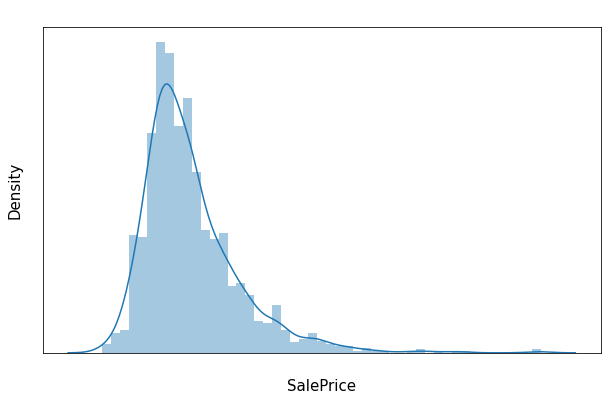

In [35]:
plt.rcParams['figure.figsize']=(10,6) # figsize 변경
plt.title('Original Sale Price Histogram') # 제목
sns.distplot(house_df['SalePrice']) # SalePrice distplot
plt.show()
# right skewed 되있음을 확인

#### **로그 변환을 통해 SalePrice 값 분포도 변환 right skewed -> 정규분포 잘됨**

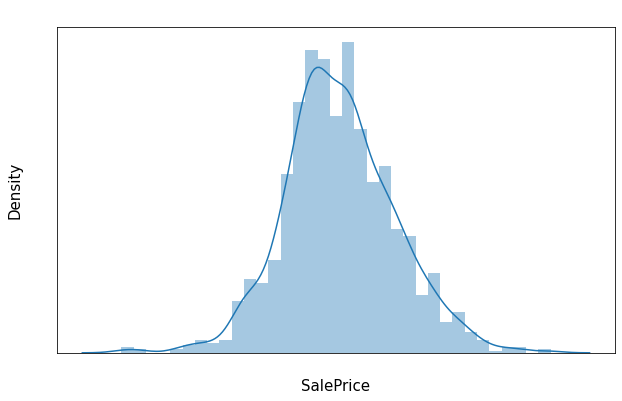

In [36]:
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(house_df['SalePrice']) # log1p 변환
sns.distplot(log_SalePrice)
plt.show()

** 타겟값인 Price를 로그변환하여 정규 분포 형태로 변환하고, 피처들 중 숫자형 컬럼의 Null값 데이터 처리 **

In [37]:
# SalePrice 로그 변환
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice']) # log1p 변환

# Null 이 너무 많은 컬럼들과 불필요한 컬럼 삭제
house_df.drop(['Id','PoolQC' , 'MiscFeature', 'Alley', 'Fence','FireplaceQu'], axis=1 , inplace=True)
# Drop 하지 않는 숫자형 Null컬럼들은 평균값으로 대체
house_df.fillna(house_df.mean(),inplace=True) # 숫자형 컬럼에 대해 알아서, 해당 컬럼의 평균값으로 Null값 채운다.

# Null 값이 있는 피처명과 타입을 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum() > 0]
print("Null값 존재하는 피처들과 Null 개수")
display(null_column_count.sort_values(ascending=False).to_frame().T)
print('## Null 피처의 Type :\n')
house_df.dtypes[null_column_count.index].to_frame().T

Null값 존재하는 피처들과 Null 개수


,GarageType,GarageFinish,GarageQual,GarageCond,BsmtExposure,BsmtFinType2,BsmtQual,BsmtCond,BsmtFinType1,MasVnrType,Electrical
0,81,81,81,81,38,38,37,37,37,8,1


## Null 피처의 Type :



,MasVnrType,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Electrical,GarageType,GarageFinish,GarageQual,GarageCond
0,object,object,object,object,object,object,object,object,object,object,object


**문자열값은 모두 카테고리값. 판다스의 get_dummies( )를 이용하여 원-핫 인코딩 수행**
- get_dummies()는 null값을 반영하여 자동 원-핫 인코딩 수행

In [38]:
s1 = ['a', 'b', np.nan]
pd.get_dummies(s1, dummy_na=False)

,a,b
0,1,0
1,0,1
2,0,0


In [39]:
print('get_dummies() 수행 전 데이터 Shape:', house_df.shape)
house_df_ohe = pd.get_dummies(house_df) # 문자열 컬럼을 one-hot encoding으로 변환
print('get_dummies() 수행 후 데이터 Shape:', house_df_ohe.shape)

null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum() > 0]
print('## Null 피처의 Type :\n', house_df_ohe.dtypes[null_column_count.index]) # Null존재하는 컬럼 확인 -> 없음

get_dummies() 수행 전 데이터 Shape: (1460, 75)
get_dummies() 수행 후 데이터 Shape: (1460, 271)
## Null 피처의 Type :
 Series([], dtype: object)


In [40]:
house_df_ohe.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,1,0,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,0,0,1,0,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,1,0,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,0,0,1,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,1,0,0,0,0,1,0


### 선형 회귀 모델의 학습/예측/평가

#### **RMSE 평가 함수 생성**
: RMSE 평가 함수 생성 타겟값을 로그 변환하여, 학습한 모델은 예측값도 원본 데이터에 로그 스케일로 예측.<br>
실제 타겟값도 로그스케일, 예측값도 로그스케일이므로 RMSE를 적용하면 자연스럽게 RMSLE로 적용된다.

In [41]:
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test , pred)
    rmse = np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    return rmse

def get_rmses(models):
    rmses = [ ]
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

#### **LinearRegression, Ridge, Lasso 학습, 예측, 평가** 

In [42]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)
# Lasso의 RMSLE가 특히 높게 나옴(성능 안좋음). 이유는?

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.128
Lasso 로그 변환된 RMSE: 0.176


[0.13189576579154821, 0.12750846334052984, 0.1762825055647141]

**회귀 계수값과 컬럼명 시각화를 위해 상위 10개, 하위 10개(-값으로 가장 큰 10개) 회귀 계수값과 컬럼명을 가지는 Series생성 함수.**  

In [43]:
def get_top_bottom_coef(model):
    # coef_ 속성을 기반으로 Series 객체를 생성. index는 컬럼명. 
    coef = pd.Series(model.coef_, index=X_features.columns)
    
    # + 상위 10개 , - 하위 10개 coefficient 추출하여 반환.
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
    return coef_high, coef_low


** 인자로 입력되는 여러개의 회귀 모델들에 대한 회귀계수값과 컬럼명 시각화 **

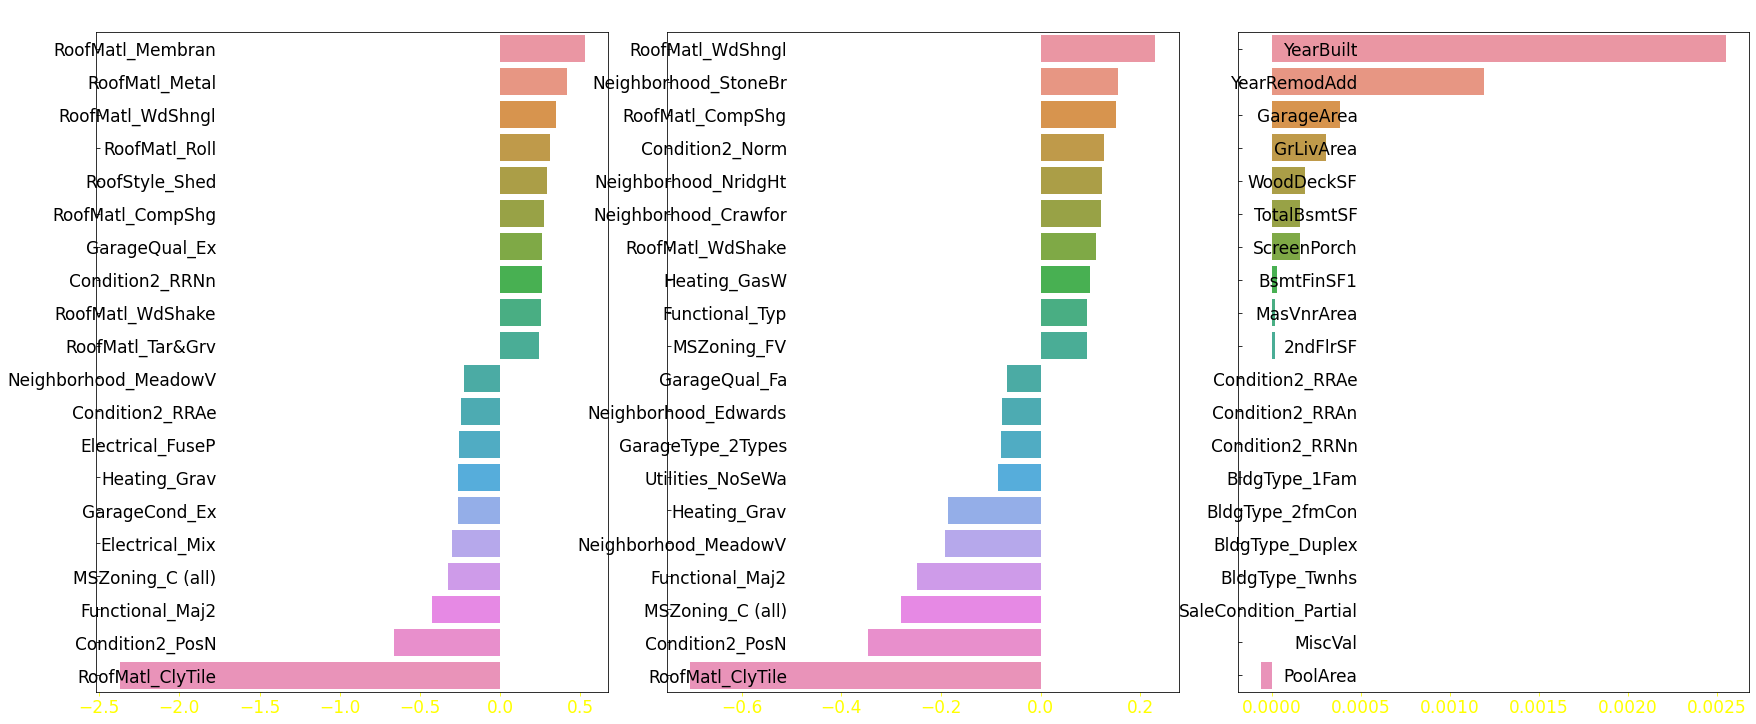

In [59]:
plt.rcParams['xtick.color']='yellow' # x축 tick 색 변경
plt.rcParams['ytick.color']='black' # y축 tick 색 변경
def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=3)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 회귀 계수 시각화. 
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합. 
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat( [coef_high , coef_low] )
        
        # 순차적으로 ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정. 
        axs[i_num].set_title(model.__class__.__name__+' Coeffiecents', size=25)
        axs[i_num].tick_params(axis="y",direction="in", pad=-120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(17)
        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i_num])

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 회귀 계수 시각화.    
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

#### **5 폴드 교차검증으로 모델별로 RMSE와 평균 RMSE출력**
5폴드 한 이유: 데이터가 1400개 수준으로 작아서 학습데이터를 4/5 수준으로 가져가기 위해 5정도 줬다.

In [60]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    for model in models:
        # 분할하지 않고 전체 데이터로 cross_val_score( ) 수행. 모델별 CV RMSE값과 평균 RMSE 출력
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target,
                                             scoring="neg_mean_squared_error", cv = 5))
        rmse_avg = np.mean(rmse_list)
        print('\n{0} CV RMSE 값 리스트: {1}'.format( model.__class__.__name__, np.round(rmse_list, 3)))
        print('{0} CV 평균 RMSE 값: {1}'.format( model.__class__.__name__, np.round(rmse_avg, 3)))

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 CV RMSE값 출력           
models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


LinearRegression CV RMSE 값 리스트: [0.135 0.165 0.168 0.111 0.198]
LinearRegression CV 평균 RMSE 값: 0.155

Ridge CV RMSE 값 리스트: [0.117 0.154 0.142 0.117 0.189]
Ridge CV 평균 RMSE 값: 0.144

Lasso CV RMSE 값 리스트: [0.161 0.204 0.177 0.181 0.265]
Lasso CV 평균 RMSE 값: 0.198


#### GridSearch - 하이퍼파라미터 튜닝
**각 모델들의 alpha값을 변경하면서 하이퍼 파라미터 튜닝 후 다시 재 학습/예측/평가** 

In [61]:
from sklearn.model_selection import GridSearchCV

def get_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, # neg값 쓰는 이유: 수치가 높을수록 성능이 좋다고 판단하는데 rmse, mse는 수치가 낮을수록 성능이 좋기 때문에 -를 줘서,
                              scoring='neg_mean_squared_error', cv=5) ## rmse수치가 낮을 수록, 음의 수치는 커져서 그리드서치가 성능좋을 때를 판단하게 하기 위해서 사용.
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_rige = get_best_params(ridge_reg, ridge_params) # 객체만 넣어주면 된다. 어차피 함수안에서 새로 다시 학습하니까.
best_lasso = get_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1418, 최적 alpha:{'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.142, 최적 alpha:{'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.124
Lasso 로그 변환된 RMSE: 0.12


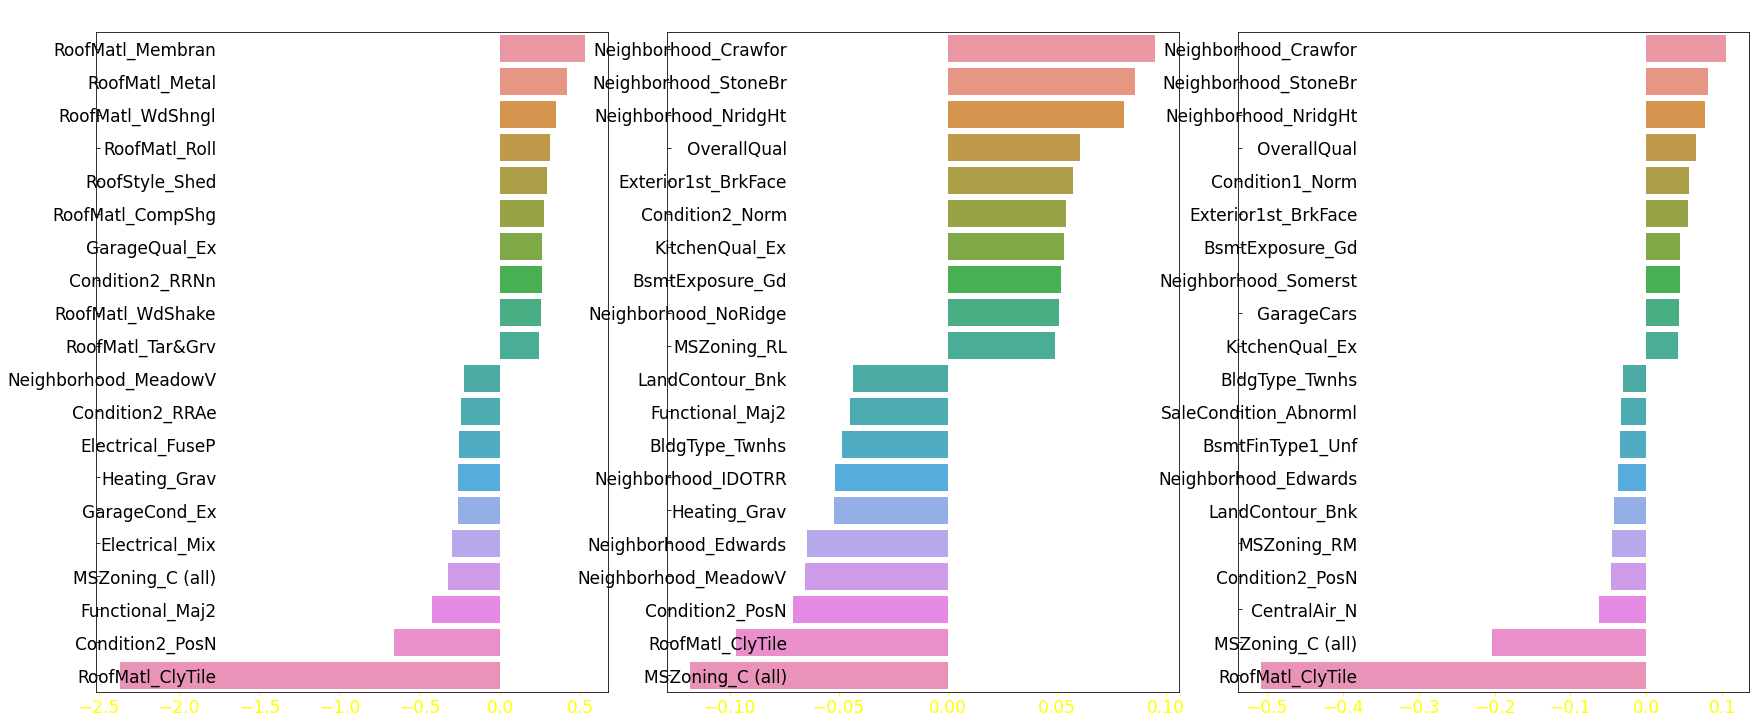

In [62]:
# 앞의 최적화 alpha값으로 릿지, 라쏘 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행. 
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

** 숫자 피처들에 대한 데이터 분포 왜곡도 확인 후 높은 왜곡도를 가지는 피처 추출 **

In [14]:
from scipy.stats import skew

# object가 아닌 숫자형 피쳐의 컬럼 index 객체 추출.
features_index = house_df.dtypes[house_df.dtypes != 'object'].index

# house_df에 컬럼 index를 [ ]로 입력하면 해당하는 컬럼 데이터 셋 반환. apply lambda로 skew( )호출 
skew_features = house_df[features_index].apply(lambda x : skew(x))

# skew 정도가 1 이상인 컬럼들만 추출. 
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


** 왜곡도가 1인 피처들은 로그 변환 적용하고 다시 하이퍼 파라미터 튜닝 후 재 학습/예측/평가 **

In [18]:
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

In [19]:
# Skew가 높은 피처들을 로그 변환 했으므로 다시 원-핫 인코딩 적용 및 피처/타겟 데이터 셋 생성,
house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# 피처들을 로그 변환 후 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_ridge = get_best_params(ridge_reg, ridge_params)
best_lasso = get_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1275, 최적 alpha:{'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1252, 최적 alpha:{'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.128
Ridge 로그 변환된 RMSE: 0.122
Lasso 로그 변환된 RMSE: 0.119


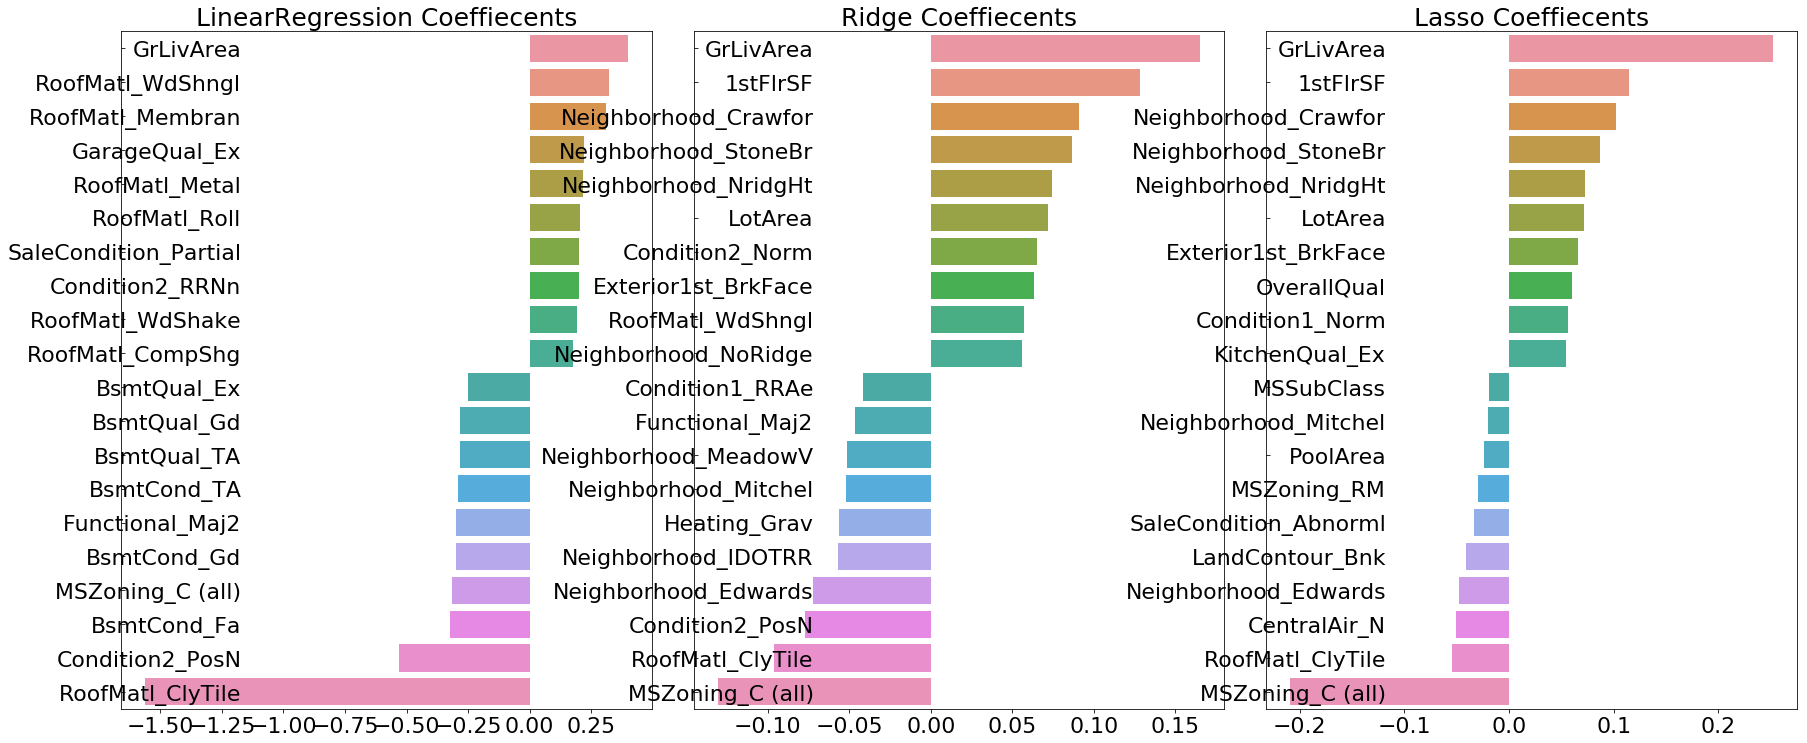

In [20]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행. 
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

** 이상치 데이터 검출을 위해 주요 피처인 GrLivArea값에 대한 산포도 확인 **

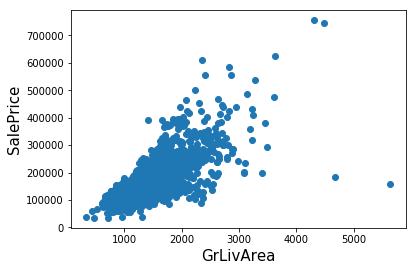

In [21]:
plt.scatter(x = house_df_org['GrLivArea'], y = house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()


** 이상치 데이터 삭제 후 재 학습/예측/평가 **

In [ ]:
house_df_ohe['GrLivArea']

In [22]:
# GrLivArea와 SalePrice 모두 로그 변환되었으므로 이를 반영한 조건 생성. 
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index

print('아웃라이어 레코드 index :', outlier_index.values)
print('아웃라이어 삭제 전 house_df_ohe shape:', house_df_ohe.shape)
# DataFrame의 index를 이용하여 아웃라이어 레코드 삭제. 
house_df_ohe.drop(outlier_index, axis=0, inplace=True)
print('아웃라이어 삭제 후 house_df_ohe shape:', house_df_ohe.shape)

아웃라이어 레코드 index : [ 523 1298]
아웃라이어 삭제 전 house_df_ohe shape: (1460, 271)
아웃라이어 삭제 후 house_df_ohe shape: (1458, 271)


In [23]:
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_ridge = get_best_params(ridge_reg, ridge_params)
best_lasso = get_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1125, 최적 alpha:{'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1122, 최적 alpha:{'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.129
Ridge 로그 변환된 RMSE: 0.103
Lasso 로그 변환된 RMSE: 0.1


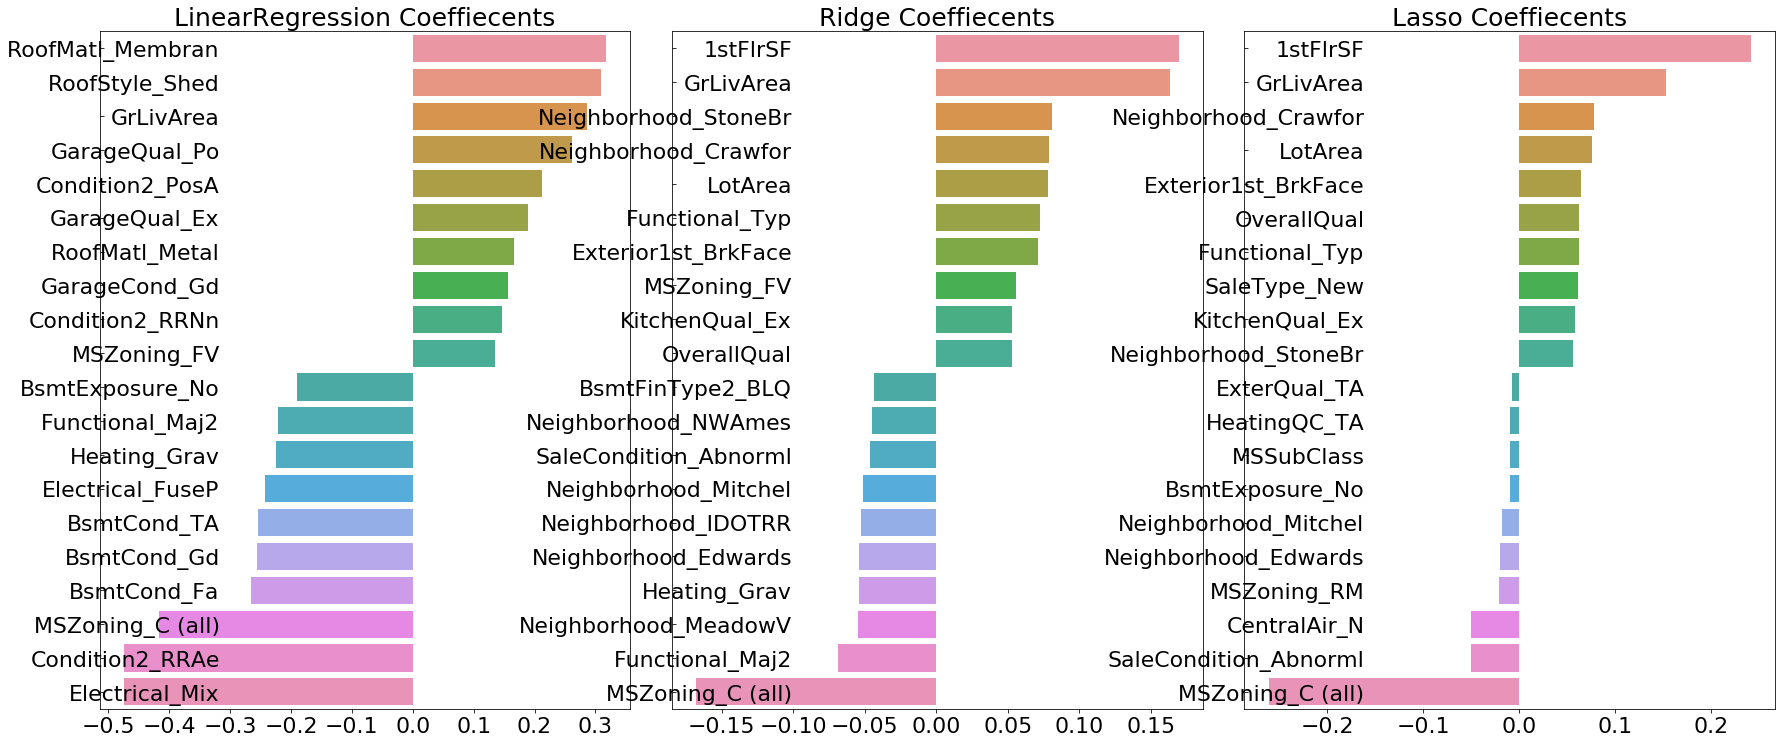

In [24]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행. 
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

### 회귀 트리 학습/예측/평가 

** XGBoost와 LightGBM 학습/예측/평가 **

In [25]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, 
                       colsample_bytree=0.5, subsample=0.8)
best_xgb = get_best_params(xgb_reg, xgb_params)

XGBRegressor 5 CV 시 최적 평균 RMSE 값: 0.1152, 최적 alpha:{'n_estimators': 1000}


In [26]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
best_lgbm = get_best_params(lgbm_reg, lgbm_params)

LGBMRegressor 5 CV 시 최적 평균 RMSE 값: 0.1168, 최적 alpha:{'n_estimators': 1000}


** 트리 회귀 모델의 피처 중요도 시각화 **

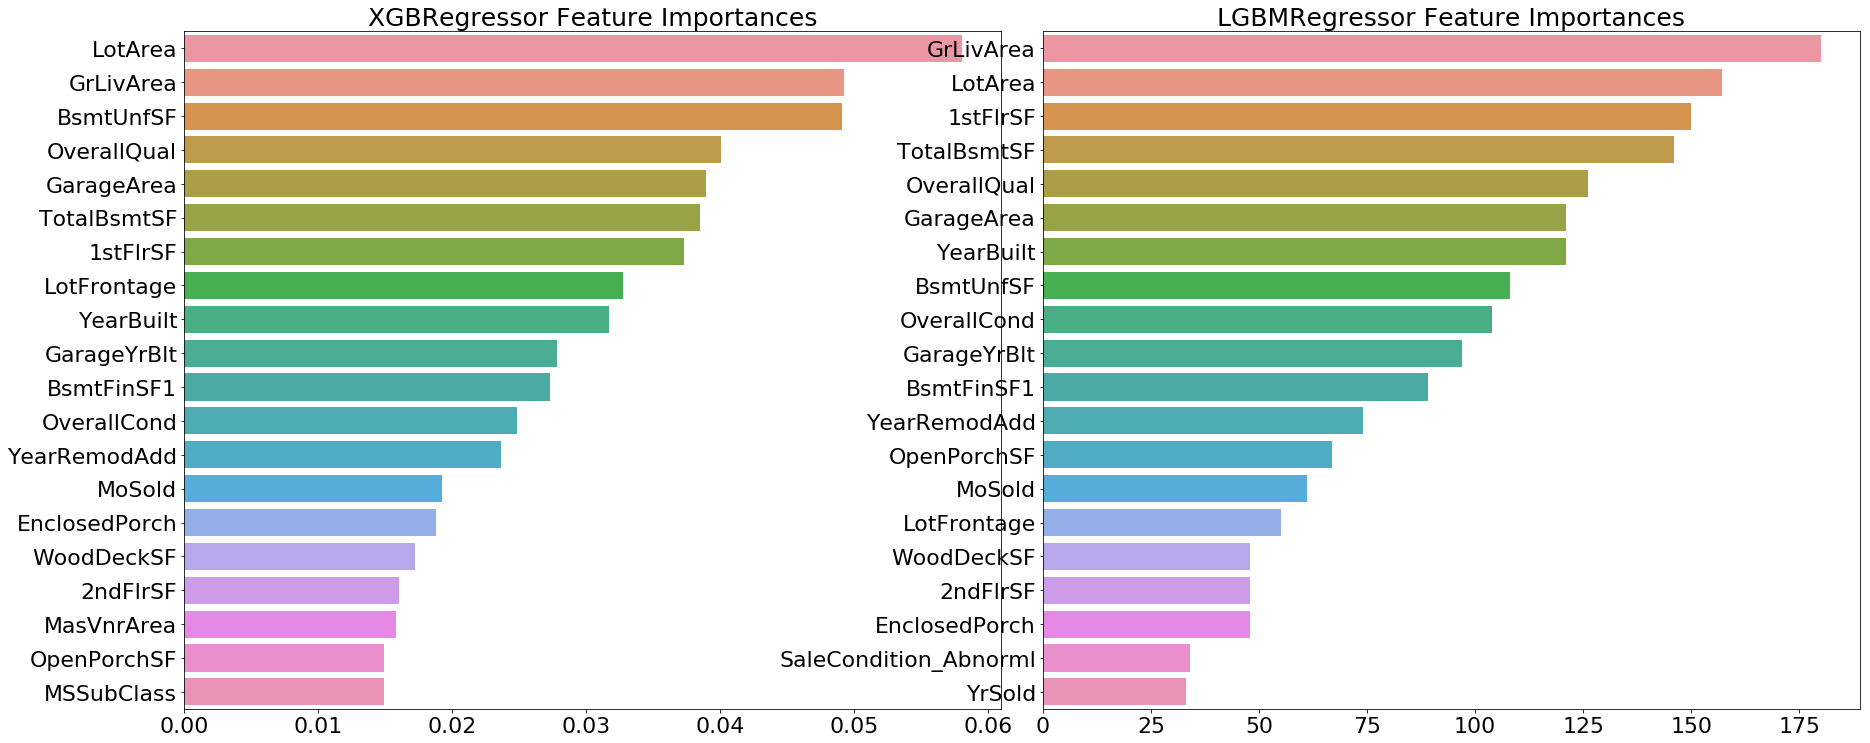

In [27]:
# 모델의 중요도 상위 20개의 피처명과 그때의 중요도값을 Series로 반환.
def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=X_features.columns  )
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    return ftr_top20

def visualize_ftr_importances(models):
    # 2개 회귀 모델의 시각화를 위해 2개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=2)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 피처 중요도 시각화. 
    for i_num, model in enumerate(models):
        # 중요도 상위 20개의 피처명과 그때의 중요도값 추출 
        ftr_top20 = get_top_features(model)
        axs[i_num].set_title(model.__class__.__name__+' Feature Importances', size=25)
        #font 크기 조정.
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=ftr_top20.values, y=ftr_top20.index , ax=axs[i_num])

# 앞 예제에서 get_best_params( )가 반환한 GridSearchCV로 최적화된 모델의 피처 중요도 시각화    
models = [best_xgb, best_lgbm]
visualize_ftr_importances(models)


### 회귀 모델들의 예측 결과 혼합을 통한 최종 예측

In [28]:
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test , pred_value)
        rmse = np.sqrt(mse)
        print('{0} 모델의 RMSE: {1}'.format(key, rmse))

# 개별 모델의 학습
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)
# 개별 모델 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 개별 모델 예측값 혼합으로 최종 예측값 도출
pred = 0.4 * ridge_pred + 0.6 * lasso_pred
preds = {'최종 혼합': pred,
         'Ridge': ridge_pred,
         'Lasso': lasso_pred}
#최종 혼합 모델, 개별모델의 RMSE 값 출력
get_rmse_pred(preds)


최종 혼합 모델의 RMSE: 0.10007930884470517
Ridge 모델의 RMSE: 0.10345177546603249
Lasso 모델의 RMSE: 0.10024170460890039


In [29]:
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, 
                       colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)

pred = 0.5 * xgb_pred + 0.5 * lgbm_pred
preds = {'최종 혼합': pred,
         'XGBM': xgb_pred,
         'LGBM': lgbm_pred}
        
get_rmse_pred(preds)


최종 혼합 모델의 RMSE: 0.10120908122913022
XGBM 모델의 RMSE: 0.10669588503339805
LGBM 모델의 RMSE: 0.10321866205316597


### 스태킹 모델을 통한 회귀 예측

In [30]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수. 
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False, random_state=0)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')
    
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]  
        
        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)       
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(X_test_n)
            
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

** 기반 모델은 리지, 라소, XGBoost, LightGBM 으로 만들고 최종 메타 모델은 라소로 생성하여 학습/예측/평가 **

In [31]:
# get_stacking_base_datasets( )은 넘파이 ndarray를 인자로 사용하므로 DataFrame을 넘파이로 변환. 
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

# 각 개별 기반(Base)모델이 생성한 학습용/테스트용 데이터 반환. 
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)  
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)



Ridge  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
Lasso  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
XGBRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
LGBMRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 


In [32]:
# 개별 모델이 반환한 학습 및 테스트용 데이터 세트를 Stacking 형태로 결합.  
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, 
                                      xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, 
                                     xgb_test, lgbm_test), axis=1)

# 최종 메타 모델은 라쏘 모델을 적용. 
meta_model_lasso = Lasso(alpha=0.0005)

#기반 모델의 예측값을 기반으로 새롭게 만들어진 학습 및 테스트용 데이터로 예측하고 RMSE 측정.
meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test , final)
rmse = np.sqrt(mse)
print('스태킹 회귀 모델의 최종 RMSE 값은:', rmse)



스태킹 회귀 모델의 최종 RMSE 값은: 0.09749379255891891
